In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import json
import matplotlib.pyplot as plt
import ast
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from statsmodels import tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import json


## Data Loading

In [4]:
# load bechdel
bechdel_df = pd.read_csv('data/processed/bechdel_ratings.csv')

# load characters metadata
char_metadata_df = pd.read_csv("data/processed/characters_metadata.csv")

# load directors
movie_directors = pd.read_csv('data/processed/movies_director.csv')

# load emotions
plot_emotion_df = pd.read_csv("data/processed/plot_emotions.csv")

# load movies
movies_df = pd.read_csv("data/processed/movies_metadata.csv")

# transform movies
movies_df = movies_df[["wikipedia_movie_id", "movie_release_date", "movie_genres", "movie_countries"]]
# groupby to make a list that contains all genders for a given movie
genders_grouped = (
    char_metadata_df.groupby("wikipedia_movie_id")["actor_gender"]
    .apply(list)  # Collect genders into lists
    .reset_index()  # Reset index to make it a DataFrame
    .rename(columns={"actor_gender": "actor_genders"})  # Rename the column
)
# merging
movies_df = movies_df.merge(genders_grouped, on="wikipedia_movie_id", how="left")
movies_df['movie_genres'] = movies_df['movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
movies_df['movie_countries'] = movies_df['movie_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# define male/female directors
movies_M = movie_directors[movie_directors["Gender"].apply(lambda x: x=="M")]
movies_F = movie_directors[movie_directors["Gender"].apply(lambda x: x=="F")]


## Data augmentation

In [5]:
# adding genres, countries, genders
bechdel_df = pd.merge(
    bechdel_df,
    movies_df[['wikipedia_movie_id', "movie_genres", "movie_countries", "actor_genders"]],
    how = "inner", # first line is dropped
    on = "wikipedia_movie_id"
)

# adding director gender
bechdel_df["director_gender"] = bechdel_df["wikipedia_movie_id"].apply(
    lambda x: int(0) if x in movies_M['wikipedia_movie_id'].values else 
              (int(1) if x in movies_F['wikipedia_movie_id'].values else np.nan)
)
bechdel_df = bechdel_df.dropna(subset="director_gender")

# adding plot summaries info
bechdel_df = pd.merge(
    bechdel_df,
    plot_emotion_df[['wikipedia_movie_id', "plot_length_nb_words", "emotion_scores", "dominant_emotion"]],
    how = "inner", # first line is dropped
    on = "wikipedia_movie_id"
)
# handle emotions
# Replace single quotes with double quotes
bechdel_df["emotion_scores"] = bechdel_df["emotion_scores"].str.replace("'", '"')
# Parse the corrected strings into dictionaries
bechdel_df["emotion_scores"] = bechdel_df["emotion_scores"].apply(json.loads)

In [6]:
# formatting columns for ML
# get all genres and countries
genres_list = bechdel_df.explode("movie_genres")["movie_genres"].unique().tolist()
countries_list = bechdel_df.explode("movie_countries")["movie_countries"].unique().tolist()
emotion_list = bechdel_df["dominant_emotion"].unique().tolist()
# add genre and countries columns
cols_df = pd.DataFrame(columns=["char_M", "char_F"] + genres_list + countries_list + emotion_list)
bechdel_df = pd.concat([bechdel_df, cols_df], axis=1).fillna(0).reset_index(drop=True)

for index, row in bechdel_df.iterrows():
    genres = row["movie_genres"]
    countries = row["movie_countries"]
    genders = row["actor_genders"]
    emotions_dict = row["emotion_scores"]
    for genre in genres:
        bechdel_df.at[index, genre] = 1
    for country in countries:
        bechdel_df.at[index, country] = 1
    for gender in genders:
        if gender == "M":
            bechdel_df.at[index, "char_M"] += 1
        else:
            bechdel_df.at[index, "char_F"] += 1
    for emotion in emotion_list:
        bechdel_df.at[index, emotion] = emotions_dict[emotion]

# making copy
bechdel_complete = bechdel_df.copy(deep=True)
# dropping old unformatted columns
bechdel_df = bechdel_df.drop(columns=["actor_genders", "movie_genres", "movie_countries", "actor_genders", "emotion_scores", "dominant_emotion", "wikipedia_movie_id", "movie_name"])
bechdel_df.columns = bechdel_df.columns.astype(str)

# simplifying the bechdel_rating column into 0 (fails test) and 1(passes test)
bechdel_df["bechdel_rating"] = bechdel_df["bechdel_rating"].apply(lambda x: int(0) if (x==0 or x==1 or x==2) else int(1))

Now, we have 131 columns for 3346 movies

In [8]:
bechdel_df

,movie_release_date,bechdel_rating,director_gender,plot_length_nb_words,char_M,char_F,Thriller,Science Fiction,Horror,Adventure,...,United Arab Emirates,Morocco,Puerto Rico,fear,neutral,sadness,anger,disgust,surprise,joy
0,2001,1,0.0,357,11,6,1,1,1,1,...,0,0,0,0.312076,0.261832,0.057568,0.139126,0.197780,0.014387,0.017232
1,1989,1,0.0,67,18,3,0,0,0,1,...,0,0,0,0.003841,0.679410,0.057925,0.016094,0.004746,0.129912,0.108072
2,1964,1,0.0,1468,7,6,0,0,0,0,...,0,0,0,0.063908,0.138584,0.243435,0.218646,0.036475,0.090769,0.208183
3,1989,1,1.0,583,8,6,0,0,0,0,...,0,0,0,0.148329,0.150340,0.231786,0.221961,0.123119,0.043714,0.080752
4,1939,0,0.0,244,3,1,0,0,0,0,...,0,0,0,0.257346,0.103526,0.200089,0.308751,0.044936,0.080762,0.004589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,1996,1,1.0,608,12,5,0,0,1,1,...,0,0,0,0.199097,0.345438,0.140309,0.132143,0.043645,0.030557,0.108812
3343,2011,0,0.0,808,13,4,1,1,1,1,...,0,0,0,0.069313,0.454169,0.054210,0.090608,0.153779,0.170574,0.007347
3344,1997,1,0.0,319,6,5,0,0,0,0,...,0,0,0,0.012097,0.246951,0.044272,0.088300,0.416067,0.004161,0.188152
3345,1988,1,0.0,488,15,6,0,0,0,0,...,0,0,0,0.004143,0.199333,0.211627,0.325282,0.063889,0.165895,0.029831


## Logistic Regression Model

In [20]:
# preparing data for model
target_cols = ["bechdel_rating"]
features_cols = bechdel_df.keys().tolist()
features_cols.remove(target_cols[0])
X = bechdel_df[features_cols]
y = bechdel_df[target_cols]

# we split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# we squeeze to match the dimensions
y_test = y_test.squeeze()
y_train = y_train.squeeze()

# Load the module
scaler = StandardScaler()

# Standardize X train
scaler.fit(X_train) # used both for X_train and X_test
X_train_standardized = scaler.transform(X_train)
X_test_standardized = scaler.transform(X_test)

In [22]:
# we create the model
log_reg_model = LogisticRegression(random_state=42, max_iter=500)

# Fit the model
log_reg_model.fit(X_train_standardized, y_train)

y_pred_test = log_reg_model.predict(X_test_standardized)
y_pred_train = log_reg_model.predict(X_train_standardized)
print(f'The accuracy score for test set is: {accuracy_score(y_test, y_pred_test)}')
print(f'The accuracy score for train set is: {accuracy_score(y_train, y_pred_train)}')

The accuracy score for test set is: 0.7014925373134329
The accuracy score for train set is: 0.7201046337817638


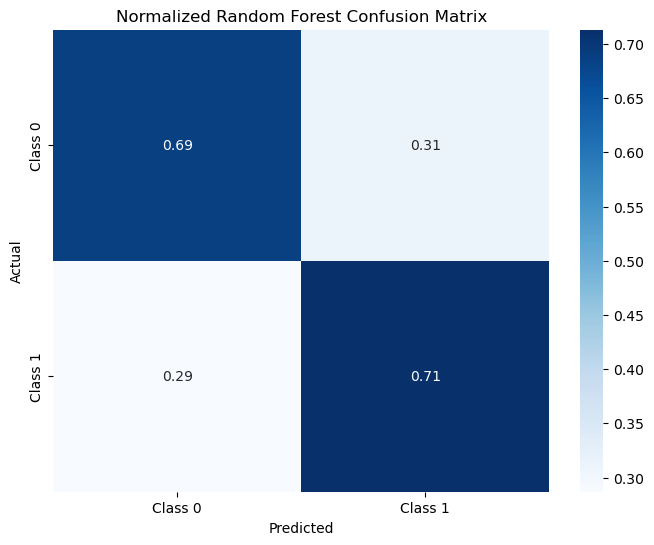

In [23]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Normalize the confusion matrix to get proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Normalized Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# Get the feature importance
selected_features = X_train.columns

# Get the coefficients from the logistic regression model
coefficients = log_reg_model.coef_[0]  # For binary classification

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Display the top 20 features
feature_importance_df.head(20)

,Feature,Coefficient,Importance
4,char_F,1.096399,1.096399
3,char_M,-0.649354,0.649354
30,Feminist,0.456757,0.456757
83,Serbia,-0.298492,0.298492
92,Egypt,0.298387,0.298387
93,Russia,-0.270955,0.270955
102,Iceland,0.250458,0.250458
96,Norway,-0.245743,0.245743
76,Lebanon,-0.235551,0.235551
79,Austria,0.223329,0.223329


## Correlation between features

In [35]:
correlations = bechdel_df[['bechdel_rating', 'char_F', 'char_M', "director_gender"]].corr()

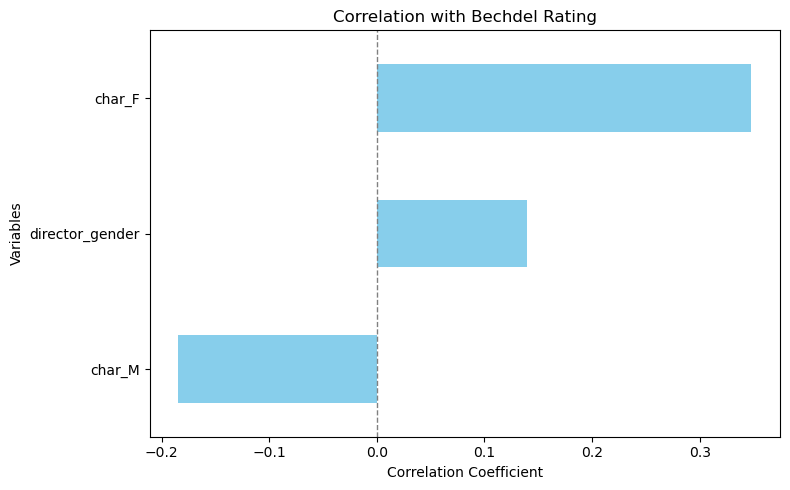

In [36]:
# Correlation values
bechdel_corr = correlations['bechdel_rating'].drop('bechdel_rating')

# Plotting
plt.figure(figsize=(8, 5))
bechdel_corr.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Correlation with Bechdel Rating')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)  # Mark zero correlation
plt.tight_layout()
plt.show()

## Further analysis

In [9]:
bechdel_complete = bechdel_complete[["wikipedia_movie_id", "movie_name", "movie_release_date", "bechdel_rating", "director_gender", "char_M", "char_F", "neutral", "sadness", "anger", "fear", "disgust", "surprise", "joy"]]

In [12]:
bechdel_complete

,wikipedia_movie_id,movie_name,movie_release_date,bechdel_rating,director_gender,char_M,char_F,neutral,sadness,anger,fear,disgust,surprise,joy
0,975900,Ghosts of Mars,2001,3,0.0,11,6,0.261832,0.057568,0.139126,0.312076,0.197780,0.014387,0.017232
1,171005,Henry V,1989,3,0.0,18,3,0.679410,0.057925,0.016094,0.003841,0.004746,0.129912,0.108072
2,77856,Mary Poppins,1964,3,0.0,7,6,0.138584,0.243435,0.218646,0.063908,0.036475,0.090769,0.208183
3,12053509,Loverboy,1989,3,1.0,8,6,0.150340,0.231786,0.221961,0.148329,0.123119,0.043714,0.080752
4,1369204,Juarez,1939,2,0.0,3,1,0.103526,0.200089,0.308751,0.257346,0.044936,0.080762,0.004589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,303933,Twister,1996,3,1.0,12,5,0.345438,0.140309,0.132143,0.199097,0.043645,0.030557,0.108812
3343,25920477,Source Code,2011,1,0.0,13,4,0.454169,0.054210,0.090608,0.069313,0.153779,0.170574,0.007347
3344,1191380,Wilde,1997,3,0.0,6,5,0.246951,0.044272,0.088300,0.012097,0.416067,0.004161,0.188152
3345,54540,Coming to America,1988,3,0.0,15,6,0.199333,0.211627,0.325282,0.004143,0.063889,0.165895,0.029831


In [11]:
# Calculate histograms for male and female directors
male_director_hist = (
    bechdel_complete[bechdel_complete['director_gender'] == 0]['bechdel_rating']
    .value_counts(normalize=True) * 100
)
female_director_hist = (
    bechdel_complete[bechdel_complete['director_gender'] == 1]['bechdel_rating']
    .value_counts(normalize=True) * 100
)

# Get all Bechdel ratings as the x-axis
x = bechdel_complete['bechdel_rating'].unique()
# Create bar traces for Male and Female Directors
trace_male = go.Bar(
    x=x,
    y=male_director_hist.values,
    name='Male Directors',
    width=0.4
)

trace_female = go.Bar(
    x=x,
    y=female_director_hist.values,
    name='Female Directors',
    width=0.4
)

# Create layout
layout = go.Layout(
    title="Bechdel Test Ratings by Gender of Directors",
    xaxis=dict(title="Bechdel Rating", tickvals=x),
    yaxis=dict(title="Percentage (%)"),
    barmode='group',  # Group the bars
    bargap=0.2  # Gap between bars
)

# Create figure and show plot
fig = go.Figure(data=[trace_male, trace_female], layout=layout)
fig.show()


Keep going...

In [14]:
bechdel_complete_grade3 = bechdel_complete[bechdel_complete["bechdel_rating"]==3]
bechdel_complete_grade012 = bechdel_complete[bechdel_complete["bechdel_rating"]!=3]

In [ ]:
bechdel_complete_grade3_men = bechdel_complete_grade3[bechdel_complete_grade3["director_gender"]==0]
bechdel_complete_grade3_women = bechdel_complete_grade3[bechdel_complete_grade3["director_gender"]==1]
bechdel_complete_grade012_men = bechdel_complete_grade012[bechdel_complete_grade012["director_gender"]==0]
bechdel_complete_grade012_women = bechdel_complete_grade012[bechdel_complete_grade012["director_gender"]==1]

In [21]:
bechdel_complete_grade012_men

,wikipedia_movie_id,movie_name,movie_release_date,bechdel_rating,director_gender,char_M,char_F,neutral,sadness,anger,fear,disgust,surprise,joy
4,1369204,Juarez,1939,2,0.0,3,1,0.103526,0.200089,0.308751,0.257346,0.044936,0.080762,0.004589
7,1765938,Convoy,1978,0,0.0,6,2,0.188848,0.122047,0.369908,0.090259,0.211473,0.013506,0.003959
8,1305819,C.H.U.D.,1984,2,0.0,10,5,0.214682,0.022726,0.074407,0.429979,0.226658,0.022725,0.008822
10,196176,Straw Dogs,1971,1,0.0,9,2,0.074969,0.075158,0.439392,0.277693,0.116319,0.010310,0.006159
14,27463222,Vanishing on 7th Street,2010,1,0.0,9,5,0.306420,0.087873,0.069890,0.355545,0.065697,0.110008,0.004567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336,1138104,Beverly Hills Cop III,1994,0,0.0,13,1,0.257634,0.357050,0.173763,0.101291,0.009355,0.069399,0.031508
3338,883432,Gone in Sixty Seconds,2000,1,0.0,13,1,0.202137,0.041716,0.334272,0.310900,0.009307,0.065926,0.035741
3340,22427855,Adam,2009,2,0.0,8,7,0.172165,0.226913,0.165479,0.197138,0.043898,0.180865,0.013542
3343,25920477,Source Code,2011,1,0.0,13,4,0.454169,0.054210,0.090608,0.069313,0.153779,0.170574,0.007347


In [41]:
# Calcul de la moyenne des émotions pour chaque DataFrame
def compute_mean_emotions(df):
    emotions = ["neutral", "sadness", "anger", "fear", "disgust", "surprise", "joy"]
    return df[emotions].mean()

# Moyennes des émotions pour chaque groupe
data_women_grade3 = compute_mean_emotions(bechdel_complete_grade3_women)
data_men_grade3 = compute_mean_emotions(bechdel_complete_grade3_men)
data_women_grade012 = compute_mean_emotions(bechdel_complete_grade012_women)
data_men_grade012 = compute_mean_emotions(bechdel_complete_grade012_men)

# Création du graphique radar
fig = go.Figure()

# Ajout des données pour chaque groupe

fig.add_trace(go.Scatterpolar(
    r=data_women_grade012,
    theta=data_women_grade012.index,
    fill='toself',
    name='Women Grade 0-12',
    line_color='rgb(102, 204, 255)'
    ))

fig.add_trace(go.Scatterpolar(
    r=data_men_grade012,
    theta=data_men_grade012.index,
    fill='toself',
    name='Men Grade 0-12', 
    line_color='rgb(255, 153, 51)'
    ))

fig.add_trace(go.Scatterpolar(
    r=data_women_grade3,
    theta=data_women_grade3.index,
    fill='toself',
    name='Women Grade 3',
    marker_color='royalblue',
    ))

fig.add_trace(go.Scatterpolar(
    r=data_men_grade3,
    theta=data_men_grade3.index,
    fill='toself',
    name='Men Grade 3',
    marker_color='gold'
    ))

# Mise en forme du graphique
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 0.3]  # Ajustez en fonction de vos données
        )
    ),
    title="Emotion Distribution by Gender and Bechdel Grades",
    showlegend=True
)

# Affichage
fig.show()

